In [1]:
import torch
import torchvision
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader
from module.data_processes import get_data
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from itertools import product

from typing import List, Tuple
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
# global variable
DEVICE='cpu'

In [3]:
# util functions for generating combinations of: data, model, lr, epochs, and feed into TF board for et
def process_data(
    url,
    file_name,
    model_weights,
    batch_size,
):
    train_dir, test_dir=get_data(
        data_path=f'data/{file_name}',
        data_url=url,
        unzip=True
    )

    auto_transforms=model_weights.transforms()
    trainDataset=datasets.ImageFolder(
        root=train_dir,
        transform=auto_transforms,
    ) # creating training dataset

    train_dataloader=DataLoader(
        trainDataset,
        batch_size=batch_size,
        shuffle=True,
    ) # creating training dataloader

    # getting the name and indexer of classes:
    class_name=trainDataset.classes
    class_dict=trainDataset.class_to_idx

    # setting up the testing dataset
    testDataset=datasets.ImageFolder(
        root=test_dir,
        transform=auto_transforms,
    ) # creating testing dataset

    # creating the testing dataloader
    test_dataloader=DataLoader(
        testDataset,
        batch_size=batch_size,
        shuffle=False,
    ) # creating testing dataloader
    
    return (
        train_dataloader,
        test_dataloader,
        class_name,
        class_dict,
    )


def process_model(
    model,
    model_weights,
    classes,
):
    model_loaded=model(weights=model_weights).to(DEVICE)
    # extract the last layer

    # name of the last layer
    last_layer_name=list(model_loaded._modules.keys())[-1]
    last_layer=getattr(model_loaded, last_layer_name)

    # in feature of the very last layer:
    num_in_features=getattr(last_layer,list(last_layer._modules.keys())[-1]).in_features

    new_layer=nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(
            in_features=num_in_features,
            out_features=classes
        )
    ).to(DEVICE)

    setattr(model_loaded, last_layer_name, new_layer)

    return model_loaded


def step(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device='cpu',
    infer=False,
):
    if infer:
        model.eval()
    else:
        model.train()

    currentLoss, currentMetric=0, 0
    for batch, (X,y) in enumerate(data_loader):
        X,y=X.to(device), y.to(device)
        y_pred=model(X)
        loss=loss_fn(y_pred, y)
        currentLoss += loss.item()

        if not infer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        y_pred_output=torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        currentMetric+=(y_pred_output==y).sum().item()/len(y_pred)

    currentLoss=currentLoss/len(data_loader)
    currentMetric=currentMetric/len(data_loader)
    return currentLoss, currentMetric


def learning_engine(
    writer,
    model,
    epochs,
    train_dataloader,
    test_dataloader,
    loss_fn,
    optimizer
):
    for epoch in tqdm(range(epochs), total=epochs):
        train_loss, train_acc=step(
            model=model,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=DEVICE,
            infer=False,
        )

        test_loss, test_acc=step(
            model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=DEVICE,
            infer=True,
        )
        # print(f"Epoch: {epoch} | train loss: {train_loss} | train_acc: {train_acc}")
        # print(f"test loss: {test_loss} | test_acc: {test_acc}")

        writer.add_scalars(
            main_tag='Loss',
            tag_scalar_dict={
                'train_loss':train_loss,
                'test_loss':test_loss,
            },
            global_step=epoch
        )

        writer.add_scalars(
            main_tag='Accuracy',
            tag_scalar_dict={
                'train_acc':train_acc,
                'test_acc':test_acc,
            },
            global_step=epoch
        )

        writer.add_graph(
            model=model,
            input_to_model=torch.randn(32,3,224,224).to(DEVICE)
        )
    writer.close()
    return model, test_acc


def experiment_engine(
    experiment_name,
    data_name,
    data_url,
    batch_size,
    model,
    model_weights,
    epochs,
    loss_fn,
    optimizer,
    lr,
):
    writer=SummaryWriter(log_dir=f'runs/{experiment_name}')
    (
        train_dataloader,
        test_dataloader,
        class_name,
        class_dict,
    )=process_data(
        data_url,
        data_name,
        model_weights,
        batch_size,
    )

    model=process_model(
        model,
        model_weights,
        len(class_name),
    )

    optimizer=optimizer(model.parameters(), lr=lr)
    trained_model, final_test_acc=learning_engine(
        writer,
        model,
        epochs,
        train_dataloader,
        test_dataloader,
        loss_fn,
        optimizer
    )
    return trained_model, final_test_acc

In [4]:
data={
    '10_perc':'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
    '20_perc':'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip'
}
batch_sizes={
    's_batch':16,
}

models={
    'b0':(torchvision.models.efficientnet_b0,torchvision.models.EfficientNet_B0_Weights.DEFAULT),
    'b2':(torchvision.models.efficientnet_b2,torchvision.models.EfficientNet_B2_Weights.DEFAULT),
}

epochs={
    '5ep':5,
    '10ep':10,
}

loss_fn={'ce':torch.nn.CrossEntropyLoss()}
optimizer={'adam':torch.optim.Adam}
lr={'s_lr':1e-4,'m_lr':0.001}

In [5]:
combos=list(
    product(
        data.items(),
        batch_sizes.items(),
        models.items(),
        epochs.items(),
        loss_fn.items(),
        optimizer.items(),
        lr.items()
    )
)

In [6]:
trained_models={}
experiment_names=[]
for combo in combos:
    experiment_name='-'.join([c[0] for c in combo])
    experiment_names.append(experiment_name)
    data_name=combo[0][0]
    data_url=combo[0][1]
    batch_size=combo[1][1]
    model=combo[2][1][0]
    model_weights=combo[2][1][1]
    epochs=combo[3][1]
    loss_fn=combo[4][1]
    optimizer=combo[5][1]
    lr=combo[6][1]
    
    trained_model, final_test_acc=experiment_engine(
        experiment_name,
        data_name,
        data_url,
        batch_size,
        model,
        model_weights,
        epochs,
        loss_fn,
        optimizer,
        lr,
    )
    trained_models[experiment_name]={'model':trained_model,'final_test_acc':final_test_acc}

  0%|          | 0/5 [00:00<?, ?it/s]

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /Users/daweili/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 51.4MB/s]


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
best_model=trained_models['20_perc-s_batch-b0-10ep-ce-adam-s_lr']

In [9]:
def pred_and_plot_image(
    model,
    image_path,
    class_names,
    image_size,
    transform=None,
    device='cpu',
):
    img=Image.open(image_path)

    if transform is None:
        transform=transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                )
            ]
        )
    
    model.to(device)
    model.eval()
    with torch.inference_mode():
        transformed_image=transform(img).unsqueeze(dim=0)
        target_image_pred=model(transformed_image.to(device))
    
    target_image_pred_probs=torch.softmax(target_image_pred, dim=1)
    target_image_pred_label=torch.argmax(target_image_pred_probs, dim=1).item()
    target_image_pred_probs=target_image_pred_probs.numpy()

    plt.figure()
    plt.imshow(img)
    plt.title(f'Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs[0][target_image_pred_label]*100:.3f}%')

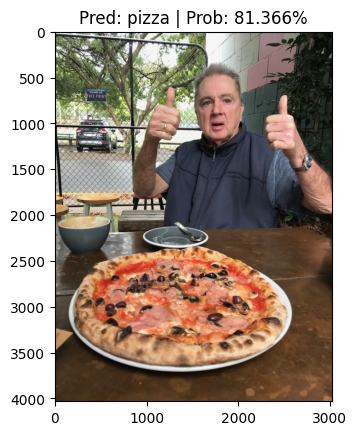

In [12]:
pred_and_plot_image(
    best_model['model'],
    'data/eval/04-pizza-dad.jpeg',
    ['pizza','steak','sushi'],
    image_size=(224,224),
    transform=torchvision.models.EfficientNet_B0_Weights.DEFAULT.transforms(),
    device='cpu',
)